In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import normal

### **00.** 트레이닝 셋 생성

In [2]:
np.random.seed(0)

N = 10           # 샘플을 취득하는 위치 x의 개수
Ms = [0,1,3,9]     # 그래프로 표현할 다항식의 차수

In [3]:
# 데이터 셋 생성 함수(create_dataset) 선언하기
# 데이터셋 {x_n,t_n} (n=1...N))
def create_dataset(N):
    dataset = pd.DataFrame(columns=['x','t'])
    for i in range(N):
        x = float(i)/float(N-1)
        t = np.sin(2*np.pi*x) + normal(scale = 0.3)
        # standard deviation.
        dataset = dataset.append(pd.Series([x,t],index=['x','t']),
                                 ignore_index = True)
    return dataset

          x         t
0  0.000000  0.529216
1  0.111111  0.762835
2  0.222222  1.278429
3  0.333333  1.538293
4  0.444444  0.902288
5  0.555556 -0.635204
6  0.666667 -0.580999
7  0.777778 -1.030215
8  0.888889 -0.673753
9  1.000000  0.123180


Text(0.5, 1.0, 'training set')

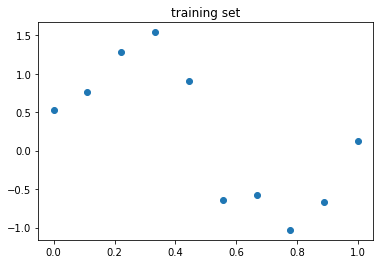

In [4]:
# 학습시킬 데이터 생성하기
training_set = create_dataset(N)

# N개의 관측점/관측값 가지는 트레이닝 셋 DataFrame 출력
print(training_set)

# 트레이닝 셋 그래프 출력
x = training_set['x'] # x는 pandas.core.series.Series 객체.
t = training_set['t'] # t는 pandas.core.series.Series 객체.

plt.scatter(x,t)
plt.title('training set')

### **01** $\mathbf{w}$ 계산


$\mathbf{w} = \left ( \mathbf{\Phi}^T \mathbf{\Phi} \right )^{-1} \mathbf{\Phi}^T \mathbf{t} $

In [5]:
# 함수 선언
def calc_phi(dataset, M): #dataset: x,t를 행으로 가지는 데이터
    x = dataset.x.values.reshape(-1,1)
    phi = np.repeat(x, M+1, axis = 1)
    phi = np.power(phi, np.arange(M+1))
    return phi

def calc_t(dataset):
    return dataset.t.values.reshape(-1,1)

def calc_w(dataset, M):
    phi = calc_phi(dataset,M)
    t = calc_t(dataset)

    phiT_phi_inv = np.linalg.inv(phi.T.dot(phi))
    w = np.linalg.multi_dot([phiT_phi_inv,phi.T,t])
    return w
    
def calc_polynomial(w, xs):
    ys = np.zeros(xs.size)
    w = w.flatten()
    for i, w_i in enumerate(w):
        ys += w_i * (xs ** i)
    return ys

### **02.** $E_D, E_{rms}, \sigma$ 계산 

$E_D = \frac{1}{2} \sum_{n=1}^{N}    \left \{ f(x_n) - t_n \right \}^{2} 
\\
\sigma =  \sqrt{\frac{2E_D}{N}} = E_{RMS}$

In [7]:
# 제곱근 평균 제곱 오차(Root mean square error) 계산
def calc_Ed_Erms(dataset, w):
    Ed = 0.0
    # x value: line.x  t value: line.t
    for _, line in dataset.iterrows(): # (index, Series) pairs.
        x, t = line.x, line.t
        Ed += 0.5 * (calc_polynomial(w,x)-t)**2

    Erms = np.sqrt(2*Ed/len(dataset)) 
    return Ed, Erms



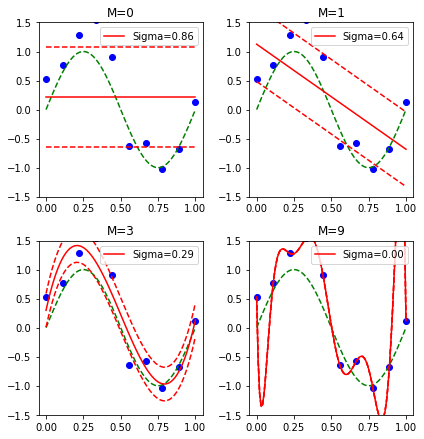

In [8]:
# 최우추정법으로 다항식 근사치를 구한 결과 시각화 하기
fig_width = 3*2
fig_height = 3*(int(len(Ms)/2)+1)
fig = plt.figure(figsize = (fig_width, fig_height))

for c, M in enumerate(Ms):

    # f, ws, sigma = resolve(training_set, M)
    
    w = calc_w(training_set,M)
    Ed, Erms = calc_Ed_Erms(training_set, w)
    sigma = Erms

    # df_ws = df_ws.append(pd.Series(ws,name="M=%d" % M))

    subplot = fig.add_subplot(int(len(Ms)/2)+1, 2, c+1)
    subplot.set_xlim(-0.05,1.05)
    subplot.set_ylim(-1.5,1.5)
    subplot.set_title("M=%d" % M)

    # 트레이닝 세트 표시
    subplot.scatter(training_set.x, training_set.t, marker='o', color='blue')

    # sin곡선을 표시
    linex = np.linspace(0,1,101)    # numpt.ndarray (101,)
    linet = np.sin(2*np.pi*linex)   # numpy.ndarray (101,)
    subplot.plot(linex, linet, color='green', linestyle='--')

    # 근사 곡선 및 표준편차 표시
    linex = np.linspace(0,1,101)   # numpt.ndarray (101,)
    linet = calc_polynomial(w,linex)
    label = "Sigma=%.2f" % sigma
    subplot.plot(linex, linet, color='red', label=label)
    subplot.plot(linex, linet+sigma, color='red', linestyle='--')
    subplot.plot(linex, linet-sigma, color='red', linestyle='--')
    subplot.legend(loc=1)


fig.tight_layout()
fig.show()

### **03.** $log \ likelihood$ 계산

$P=  \left ( \frac{1}{2\pi\sigma^2} \right )^{\frac{N}{2}} e^{-\frac{1}{2\sigma^2} \sum_{n=1}^{N} \left \{t_n-f(x_n) \right \}^2}
\\
\ln(P(\mathbf{w}, \beta))=\frac{N}{2} \ln(\beta) - \frac{N}{2} \ln (2\pi) - \beta E_D(\mathbf{w}) 
$

In [9]:
# 우도 계산하는 함수(log_likelihood) 선언하기
def calc_log_likelihood(dataset, w):
    N = float(len(dataset))
    Ed, Erms = calc_Ed_Erms(dataset, w)
    sigma = Erms
    beta = 1/(sigma**2)

    log_likelihood = 0.5*N*np.log(beta) - 0.5*N*np.log(2*np.pi) - beta*Ed

    return log_likelihood

   Training set   Test set
0    -12.722983 -11.044242
1     -9.765734  -7.493501
2     -9.765650  -7.485945
3     -1.794652   1.104308
4     -1.414843  -0.508880
5      1.916976  -2.786055
6      2.968141  -3.497105
7      3.919619  -4.001283
8      6.705209  -3.910280


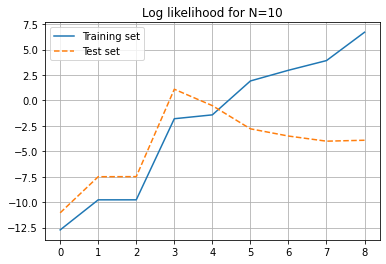

In [10]:
# 트레이닝 셋과 테스트 셋에 대한 우도 시각화
test_set = create_dataset(N)
df = pd.DataFrame()

train_llh = []
test_llh = []
for M in range(0,9):     
    w = calc_w(training_set,M)
    Ed, Erms = calc_Ed_Erms(training_set, w)
    sigma = Erms

    train_llh.append(calc_log_likelihood(training_set, w))
    test_llh.append(calc_log_likelihood(test_set, w))

df = pd.concat([df,
                pd.DataFrame(train_llh, columns=['Training set']),
                pd.DataFrame(test_llh, columns=['Test set'])],
                axis=1)

print(df)
df.plot(title='Log likelihood for N=%d' % N, grid=True, style=['-','--'])